# Model Output Validation

As part of a project I worked on at Scripps Institution of Oceanography, I performed model validation on a biogeochemical forecasting model of the Red Sea. This is a sample of some of the validation work I did on this project. This sample comes from early on in the process when we where tryin to diagnose issues with the model output.

In [1]:
#Import packages used in this project
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import matplotlib.colors as colors
from datetime import date
from datetime import datetime
from datetime import timedelta
import seawater as sw
import math
from netCDF4 import Dataset
from scipy import stats
import glob
import xarray as xr
import pandas as pd
from scipy.io import loadmat
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle


### Load initial chlorophyl, salinity, O2, and potential temp data


The data outputted from the model comes in netCDF files seperated by year, run, and variable. The data typically had a  shape around (78, 50, 2000, 2000) 

In [ ]:
#load model data
chla = nc.Dataset('/path/OUTPUT/ARCHIVE/Run1/RedSea_Run1_5day_2014_Chl.nc')
chla_14 = xr.open_dataset('/path/OUTPUT/RedSea_Run1_5day_2014_Chl.nc')
chla_15 = xr.open_dataset('/path/OUTPUT/RedSea_Run1_5day_2015_Chl.nc')
chla_16 = xr.open_dataset('/path/OUTPUT/RedSea_Run1_5day_2016_Chl.nc')
chla_142 = xr.open_dataset('/path/OUTPUT/RedSea_Run2_5day_2014_Chl.nc')
chla_152 = xr.open_dataset('/path/OUTPUT/RedSea_Run2_5day_2015_Chl.nc')
chla_162 = xr.open_dataset('/path/OUTPUT/RedSea_Run2_5day_2016_Chl.nc')

The first task with this data is converting it to a format that is better for statistical analysis and works better with python. This involves scaling each data point by their respective volumes and generating appropriate time data.

In [29]:
#Generate DataArrays
theta_g = xr.DataArray(data=theta, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})
chla_g = xr.DataArray(data=total_chla, dims=['depth', 'time'], coords={'depth': total_depth[:,0], 'time': total_times, 'lat': ('time', total_lats), 'lon': ('time', total_longs)})


In [30]:
#Create volume weights or each data point on model datasets.
weightsoc = np.empty([50, 2000,2000])
for i in range(50):
    weightsoc[i,:,:] = chla['hFacC'][i,:,:] * chla['rA'] * math.exp((chla['Z'][i])/10) 
for i in range(2000):
    for j in range(2000):
        weightsoc[:,i,j] = weightsoc[:,i,j] * chla['drF']
weights = np.empty([50, 2000,2000])
for i in range(50):
    weights[i,:,:] = chla['hFacC'][i,:,:] * chla['rA'] 
for i in range(2000):
    for j in range(2000):
        weights[:,i,j] = weights[:,i,j] * chla['drF'] 

In [ ]:
#Save weights
ncfile = Dataset('/home/pnaylor/RedSea/model_weights_2.nc', mode='w', format = 'NETCDF4_CLASSIC')
depth_dim = ncfile.createDimension('depth', 50)
lat_dim = ncfile.createDimension('lat', 2000)
lon_dim = ncfile.createDimension('lon', 2000)
ncfile.title = 'Model Weights for Statistical Analysis'
weights_oc = ncfile.createVariable('weights_oc', np.float64, ('depth', 'lat', 'lon'))
weights_oc[:,:,:] = weightsoc[:,:,:]
weights_nc = ncfile.createVariable('weights', np.float64, ('depth', 'lat', 'lon'))
weights_nc[:,:,:] = weights
ncfile.close()


In [ ]:
#Load pre generated weights
weights = nc.Dataset('/home/pnaylor/RedSea/model_weights_2.nc')

In [ ]:
#Combine time data into single array with a python frendly datatype
time_14 = np.array(chla_14['time'])
time_15 = np.array(chla_15['time'])
time_16 = np.array(chla_16['time'])
total_time = np.concatenate((time_14, time_15, time_16))
dates = pd.DatetimeIndex(total_time)
total_months = dates.month
#print((total_months))
#print(type(dates))

In [ ]:
#Generate lists of months
#print(chla['time'])
day_time = []
for i in range(109):
    day_time.append(735248 + (5*(i+1)))
def converted_datenum(times):
    new_times = []
    for i in range(len(times)):
        new_times.append(datetime.fromordinal(int(times[i])))
    return(new_times)
datetimes = converted_datenum(day_time)
months = []
for i in range(70):
    months.append(int(datetimes[i].strftime('%Y%m')))

Because the model data is being compared to satellite ocean color data, it is important to create a data product with the modeled data that resembles the ocean color data. To do this an attenuation curve is applied as a weight so that the model data can be summed to show how the chlorophyll concentration would approximately be reported by a satellite.The constants of this function based PAR data from a float in the red sea.
    
#### The attenuation function:
$$
1126(.71e^{Z/20} + (.29)e^{Z/1})
$$

In [ ]:
#Create weighted boxes for light attenuation to loosely match Ocean Color
#print(chla['Z'][:])

depth = np.flip(np.array(chla['Z'][:]))
a = .71
d1 = 20
d2 = 1
y=[]
for i in range(len(depth)):
    y.append((a*math.exp((depth[i])/d1) + (1-a)*math.exp((depth[i])/d2))*1126)
y = np.flip(y) 
drF_weighted = chla['drF']*y 
drF_weighted = np.array(drF_weighted)

## Compare modeled data to Ocean Color data

The ocean color data was supplied to us in monthly arrays over  20 years. For this comparison we use both the year matched arrays as well as the 20 year monthly average data. The model runs from 2014 - 2016, but at this phase the year had very little to do with the output; comparing the data to both sets was necessary.

In [7]:
#Load ocean color monthly averages created earlier
oc_monthly_averages = [np.genfromtxt('OC/january_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/february_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/march_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/april_average_chlorophyll.csv', delimiter=','),np.genfromtxt('OC/may_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/june_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/july_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/august_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/september_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/october_average_chlorophyll.csv', delimiter=','), np.genfromtxt('OC/november_average_chlorophyll.csv', delimiter=',') ,np.genfromtxt('OC/december_average_chlorophyll.csv', delimiter=',')]

In [9]:
#Load the raw 20yr ocean color data
list_of_paths = glob.glob('OC/*.nc', recursive=True)
list_of_paths.sort()
oc_1415 = []
for i in range(len(list_of_paths)):
    oc_1415.append(nc.Dataset(list_of_paths[i])['Tchl'][:,:])
for i in range(len(list_of_paths)):
    oc_1415[i][np.isnan(oc_1415[i])] = 0

In [10]:
#Define box for which data needs to be kept
lat = np.linspace(10.01, 30.0, 1920)
lon = np.linspace(32.01, 44.01, 1152)

In [11]:
#interpolate monthly averaged ocean color data to match shape of modeled data
for i in range(len(oc_monthly_averages)):
    oc = xr.DataArray(data=np.flip(oc_monthly_averages[i],0), dims=['lat', 'lon'], coords=[lat,lon])
    new_lat = np.linspace(oc.lat[0], oc.lat[-1], 2000)
    new_lon = np.linspace(oc.lon[0], oc.lon[-1], 1200)
    oci = oc.interp(lat=new_lat, lon=new_lon)
    oc_monthly_averages[i] = oci.data
    
#Replace nans with 0
for i in range(12):
    oc_monthly_averages[i][np.isnan(oc_monthly_averages[i])] = 0
    
#Set values outside of Sea(lakes and rivers) to zero
for i in range(len(oc_monthly_averages)):
    oc_monthly_averages[i][:250, 900:1000] = 0
    oc_monthly_averages[i][:500, 400:600] = 0
    oc_monthly_averages[i][1250:1500, 0:200] = 0

/home/panaylor/miniconda3/envs/RedSea/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/panaylor/miniconda3/envs/RedSea/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [14]:
#Generate time Series
list_of_paths = glob.glob('OC/*.nc', recursive=True)
list_of_paths.sort()
oc_1415 = []
for i in range(len(list_of_paths)):
    oc_1415.append(nc.Dataset(list_of_paths[i])['Tchl'][:,:])
for i in range(len(list_of_paths)):
    oc_1415[i][np.isnan(oc_1415[i])] = 0




#Interpolate data to match shape of modeled data
for i in range(len(oc_1415)):
    oc = xr.DataArray(data=np.flip(oc_1415[i],0), dims=['lat', 'lon'], coords=[lat,lon])
    new_lat = np.linspace(oc.lat[0], oc.lat[-1], 2000)
    new_lon = np.linspace(oc.lon[0], oc.lon[-1], 1200)
    oci = oc.interp(lat=new_lat, lon=new_lon)
    oc_1415[i] = oci.data

#Set values outside of Sea(lakes and rivers) to zero   
for i in range(len(oc_1415)):
    oc_1415[i][:250, 900:1000] = 0
    oc_1415[i][:500, 400:600] = 0
    oc_1415[i][1250:1500, 0:200] = 0

In [17]:
#Generate list of months since first datapoint
total_months_a = list(total_months)
for i in range(len(total_months)):
    if(i>140):
        total_months_a[i] = total_months[i] + 24
    elif(i>67):
        total_months_a[i] = total_months[i] + 12

The physical model that the BGC model is based on is more accurate offshore than onshore. Because of this, it made sense  to seperate the data into onshore and offshore with a greater   emphasis on the accuracy of on the offshore data. This was done by creating two arrays. For the two northern sections the onshore data was any location with depth less than 200m. For the two southern sections the onshore data was any location with depth less than 500m. (pictured below)

[   0.  500. 1000. 1500. 2000.]


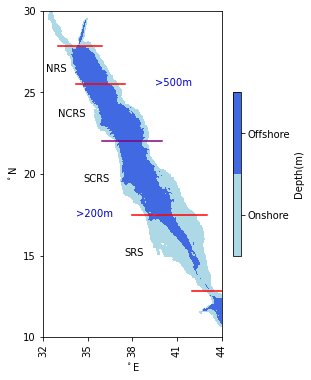

In [25]:
#plot regions and shore designation image
plt.figure(1, figsize = (4,6))
depth = np.array(chla_14['Depth'][:,:])
depth[1550:,:][(depth[1550:,:] <= 500) & (depth[1550:,:] > 0)] = 1
depth[1550:,:][depth[1550:,:] > 500] = 2
depth[:1550,:][(depth[:1550,:] <= 200) & (depth[:1550,:] > 0)] = 1
depth[:1550,:][depth[:1550,:] > 200] = 2
depth[depth == 0] = np.float('NaN')
depth = depth[:, 200:1400]
colors = ['lightblue','lightblue','royalblue', 'royalblue']
nodes = [0,.5, .5, 1]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes,colors)))
xticks = np.linspace(0,1200,5)
yticks = np.linspace(0,2000,5)
print(yticks)
xlabels = [int(chla_14['XC'][int(xticks[0] + 200)]),int(chla_14['XC'][int(xticks[1] + 200)]), int(chla_14['XC'][int(xticks[2] + 200)]), int(chla_14['XC'][int(xticks[3] + 200)]), int(chla_14['XC'][int(xticks[4]+200)])]
ylabels = [int(chla_14['YC'][int(yticks[0])]),int(chla_14['YC'][int(yticks[1]-1)]), int(chla_14['YC'][int(yticks[2]-1)]), int(chla_14['YC'][int(yticks[3]-1)]), int(chla_14['YC'][int(yticks[4]-1)])]
#print(xticks, yticks, xlabels, ylabels)                                                                 
plt.pcolormesh(depth, cmap = cmap2, vmin = .5, vmax = 2.5)
cbar = plt.colorbar(ticks=[1,2], label = 'Depth(m)', shrink=.5)
cbar.ax.set_yticklabels(['Onshore', 'Offshore'])
plt.xticks(xticks, labels=xlabels, rotation=90)
plt.yticks(yticks, labels=ylabels)
#plt.scatter([425], [1450], c='r')
#plt.legend(['Float Range'])
x1 = [1000, 1200]
y1 = [280, 280]
x2 = [600, 1100]
y2 = [750, 750]
x3 = [400, 800]
y3 = [1200, 1200]
x4 = [225, 550]
y4 = [1550, 1550]
x5 = [100, 400]
y5 = [1785, 1785]
x6 = [700, 1200]
y6 = [500, 500]
plt.plot(x1, y1, c='r')
plt.plot(x2, y2, c='r')
plt.plot(x3, y3, c= 'purple')
plt.plot(x4, y4, c='r')
plt.plot(x5, y5, c='r')
#plt.plot(x6, y6, c='r', linestyle=':')
plt.annotate('NRS', (20,1625))
plt.annotate('NCRS', (100,1350))
plt.annotate('SCRS', (275,950))
plt.annotate('SRS', (550,500))
plt.annotate('>500m', (750, 1540), c='mediumblue')
plt.annotate('>200m', (225, 740), c='mediumblue')
plt.xlabel(r'$^\circ$E')
plt.ylabel(r'$^\circ$N')

plt.savefig('updated_regions_map_flux.png', bbox_inches='tight')

In [22]:
#Generate onshore data based on depth 500
depth = chla['Depth'][:,:]
shore_depth = depth
shore_depth[shore_depth > 500] = 0
shore_depth[(shore_depth <= 500) & (shore_depth > 0)] = 1
shore_chla14 = np.array(chla_14['BLGCHL'][:,:,:,:])
shore_chla14[:,:,1200:,:] = np.array(chla_14['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])
shore_chla15 = np.array(chla_15['BLGCHL'][:,:,:,:])
shore_chla15[:,:,1200:,:] = np.array(chla_15['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])
shore_chla16 = np.array(chla_16['BLGCHL'][:,:,:,:])
shore_chla16[:,:,1200:,:] = np.array(chla_16['BLGCHL'][:,:,1200:,:] * shore_depth[1200:,:])

In [23]:
#Generate offshore data based on depth 500
depth = chla['Depth'][:,:]
offshore_depth = depth
offshore_depth[offshore_depth <= 500] = 0
offshore_depth[offshore_depth > 500] = 1
offshore_chla14 = np.array(chla_14['BLGCHL'][:,:,:,:])
offshore_chla14[:,:,1200:,:] = np.array(chla_14['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])
offshore_chla15 = np.array(chla_15['BLGCHL'][:,:,:,:])
offshore_chla15[:,:,1200:,:] = np.array(chla_15['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])
offshore_chla16 = np.array(chla_16['BLGCHL'][:,:,:,:])
offshore_chla16[:,:,1200:,:] = np.array(chla_16['BLGCHL'][:,:,1200:,:] * offshore_depth[1200:,:])

In [24]:
#Generate offshore data based on depth 200
depth = chla['Depth'][:,:]
offshore200_depth = depth
offshore200_depth[offshore200_depth <= 200] = 0
offshore200_depth[offshore200_depth > 200] = 1
offshore_chla14[:,:,:1200,:] = np.array(chla_14['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])
offshore_chla15[:,:,:1200,:] = np.array(chla_15['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])
offshore_chla16[:,:,:1200,:] = np.array(chla_16['BLGCHL'][:,:,:1200,:] * offshore200_depth[:1200,:])

In [25]:
#Generate onshore data based on depth 200
depth = chla['Depth'][:,:]
shore200_depth = depth
shore200_depth[shore200_depth > 200] = 0
shore200_depth[(shore200_depth <= 200) & (shore200_depth > 0)] = 1
shore_chla14[:,:,:1200,:] = np.array(chla_14['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])
shore_chla15[:,:,:1200,:] = np.array(chla_15['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])
shore_chla16[:,:,:1200,:] = np.array(chla_16['BLGCHL'][:,:,:1200,:] * shore200_depth[:1200,:])

In [26]:
#apply zero values to irrelevant data for offshore vs onshore ocean color data
shore_oc_1415 = []
offshore_oc_1415 = []
shore200_oc_1415 = []
offshore200_oc_1415 = []
shore_oc_ma_1415 = []
offshore_oc_ma_1415 = []
shore200_oc_ma_1415 = []
offshore200_oc_ma_1415 = []
for i in range(len(oc_1415)):
    shore_oc_1415.append(oc_1415[i] * shore_depth[:, 200:1400])
    offshore_oc_1415.append(oc_1415[i] * offshore_depth[:, 200:1400])
    shore200_oc_1415.append(oc_1415[i] * shore200_depth[:, 200:1400])
    offshore200_oc_1415.append(oc_1415[i] * offshore200_depth[:, 200:1400])
for i in range(12):
    shore_oc_ma_1415.append(oc_monthly_averages[i] * shore_depth[:, 200:1400])
    offshore_oc_ma_1415.append(oc_monthly_averages[i] * offshore_depth[:, 200:1400])
    shore200_oc_ma_1415.append(oc_monthly_averages[i] * shore200_depth[:, 200:1400])
    offshore200_oc_ma_1415.append(oc_monthly_averages[i] * offshore200_depth[:, 200:1400])

In [27]:
shore_oc_dl = [shore_oc_1415, shore_oc_1415, shore200_oc_1415, shore200_oc_1415]
offshore_oc_dl = [offshore_oc_1415, offshore_oc_1415, offshore200_oc_1415, offshore200_oc_1415]
shore_oc_ma_dl = [shore_oc_ma_1415, shore_oc_ma_1415, shore200_oc_ma_1415, shore200_oc_ma_1415]
offshore_oc_ma_dl = [offshore_oc_ma_1415, offshore_oc_ma_1415, offshore200_oc_ma_1415, offshore200_oc_ma_1415]

In [28]:
#Function for mean chlorphyll in a given range at each time instance
def time_mean(data, time_start,depth_ind, ymin, ymax, xmin, xmax, drF):
    temp = []
    sum_weights = np.empty([len(data[:,0,0,0]) - time_start, ymax-ymin, xmax-xmin])
    sum_weights[:,:,:] = 0
    for i in range(depth_ind):
        sum_weights += (data[time_start:,i,ymin:ymax,xmin:xmax] * drF[i])
    sum_weights = sum_weights / np.sum(drF[:depth_ind])
    sum_weights[sum_weights == 0] = np.float('NaN')
    for i in range(len(data[time_start:,0,0,0])):
        temp.append(np.nanmean(sum_weights[i,:,:]))
    return temp

Now that the data has been formatted and weighted it needs to be averaged. For each month of ocean color data, the onshore and offshore means are found for the 4 different regions. For the monthly averages each month is averaged and for the monthly data only the months that correspond with the model output are averaged.

In [ ]:
#Generate mean timeseries of onshore and offshore data for modeled adn oc data
#Using drF_weighted in the time_mean function applies the earlier attenuation function to the data

#Average the model data
xmins = [0, 0, 0, 0]
xmaxs = [2000, 2000, 2000, 2000]
ymins = [280, 750, 1200, 1550]
ymaxs = [750, 1200, 1550, 1785]
shore_model_box_arrays = []
offshore_model_box_arrays = []
print(1)
for i in range(4):
    print('0')
    shore_temp_14 = np.array(time_mean(np.array(shore_chla14), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('a')
    shore_temp_15 = np.array(time_mean(np.array(shore_chla15), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('b')
    shore_temp_16 = np.array(time_mean(np.array(shore_chla16), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('c')
    offshore_temp_14 = np.array(time_mean(np.array(offshore_chla14), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('d')
    offshore_temp_15 = np.array(time_mean(np.array(offshore_chla15), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('e')
    offshore_temp_16 = np.array(time_mean(np.array(offshore_chla16), 0, 50, ymins[i], ymaxs[i], xmins[i], xmaxs[i], drF_weighted))
    print('f')
    #print((temp_14), (temp_15))
    shore_model_box_arrays.append(np.concatenate([shore_temp_14,shore_temp_15, shore_temp_16]))
    print('g')
    offshore_model_box_arrays.append(np.concatenate([offshore_temp_14,offshore_temp_15, offshore_temp_16]))
    print('h')
    print((i+1)/4)
    
#Average the oc data
oc_xmins = [0, 0, 0, 0]
oc_xmaxs = [1200, 1200, 1200, 1200]
oc_ymins = [280, 750, 1200, 1550]
oc_ymaxs = [750, 1200, 1550, 1785]
shore_oc_1415_tseries = []
offshore_oc_1415_tseries = []
shore_oc_ma_1415_tseries = []
offshore_oc_ma_1415_tseries = []
print(2)
for i in range(4):
    shore_temp_1415_tseries = []
    offshore_temp_1415_tseries = []
    shore_temp_ma_1415_tseries = []
    offshore_temp_ma_1415_tseries = []
    for j in range(len(oc_1415)):
        try:
            shore_temp_1415_tseries.append(stats.tmean(shore_oc_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            shore_temp_1415_tseries.append(np.float('NaN'))
        try:
            offshore_temp_1415_tseries.append(stats.tmean(offshore_oc_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            offshore_temp_1415_tseries.append(np.float('NaN'))
        try:
            shore_temp_ma_1415_tseries.append(stats.tmean(shore_oc_ma_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))            
        except:
            shore_temp_ma_1415_tseries.append(np.float('NaN'))
        try:
            offshore_temp_ma_1415_tseries.append(stats.tmean(offshore_oc_ma_dl[i][j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]], (0.000000000001, 100)))
        except:
            offshore_temp_ma_1415_tseries.append(np.float('NaN'))
        #print(np.nanmean(oc_monthly_comp_avgs[j][oc_ymins[i]:oc_ymaxs[i], oc_xmins[i]:oc_xmaxs[i]]))
    shore_oc_1415_tseries.append(shore_temp_1415_tseries)
    offshore_oc_1415_tseries.append(offshore_temp_1415_tseries)
    shore_oc_ma_1415_tseries.append(shore_temp_ma_1415_tseries)
    offshore_oc_ma_1415_tseries.append(offshore_temp_ma_1415_tseries)
    print((i+1)/4)

#Duplicate monthly data where necessary so the shape of the oc data matches that of the modeled data
shore_oc_1415_box_tseries = []
offshore_oc_1415_box_tseries = []
shore_oc_ma_1415_box_tseries = []
offshore_oc_ma_1415_box_tseries = []
print(3)
for i in range(4):
    shore_temp_1415_tseries = []
    offshore_temp_1415_tseries = []
    shore_temp_ma_1415_tseries = []
    offshore_temp_ma_1415_tseries = []
    for j in range(len(total_months)):
        shore_temp_1415_tseries.append(shore_oc_1415_tseries[i][(total_months_a[j])-1])
        offshore_temp_1415_tseries.append(offshore_oc_1415_tseries[i][(total_months_a[j])-1])
        shore_temp_ma_1415_tseries.append(shore_oc_ma_1415_tseries[i][(total_months[j])-1])
        offshore_temp_ma_1415_tseries.append(offshore_oc_ma_1415_tseries[i][(total_months[j])-1])
    shore_oc_1415_box_tseries.append(shore_temp_1415_tseries)
    offshore_oc_1415_box_tseries.append(offshore_temp_1415_tseries)
    shore_oc_ma_1415_box_tseries.append(shore_temp_ma_1415_tseries)
    offshore_oc_ma_1415_box_tseries.append(offshore_temp_ma_1415_tseries)
    print(i/4)
plt.plot(shore_oc_1415_box_tseries[3])

4


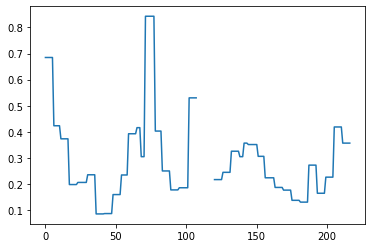

In [31]:
#Reformat arrays and generate test image
print(len(shore_oc_1415_tseries))
shore_oc_1415_final = []
offshore_oc_1415_final = []
shore_oc_ma_1415_final = []
offshore_oc_ma_1415_final = []
for i in range(1,5):
    shore_oc_1415_final.append(shore_oc_1415_box_tseries[-i])
    offshore_oc_1415_final.append(offshore_oc_1415_box_tseries[-i])
    shore_oc_ma_1415_final.append(shore_oc_ma_1415_box_tseries[-i])
    offshore_oc_ma_1415_final.append(offshore_oc_ma_1415_box_tseries[-i])
plt.plot(offshore_oc_1415_final[3])

In [32]:
#Reformat
shore_model_box_array_final = []
offshore_model_box_array_final = []
for i in range(1,5):
    shore_model_box_array_final.append(shore_model_box_arrays[-i])
    offshore_model_box_array_final.append(offshore_model_box_arrays[-i])

In [ ]:
#Unfortunately the data for the southern region of the oc monthly data is very inaccurate so it must be removed
off4 = np.linspace(0,len(total_months)-1,len(total_months))
off4[:] = np.float('NaN')
print(off4)
offshore_oc_1415_final[3] = off4
shore_oc_1415_final[3] = off4
print(offshore_oc_1415_final[3])

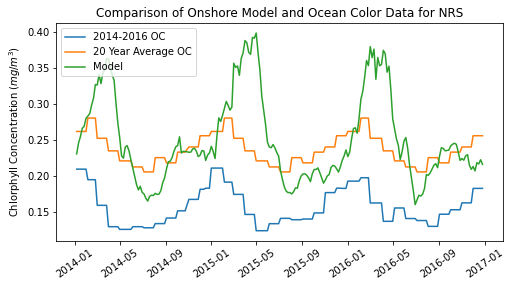

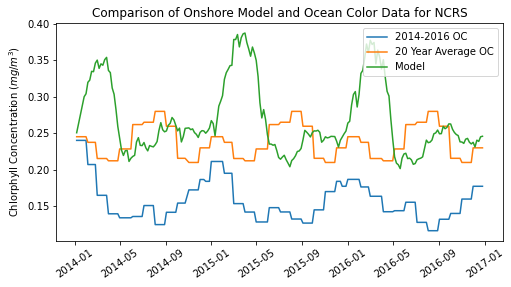

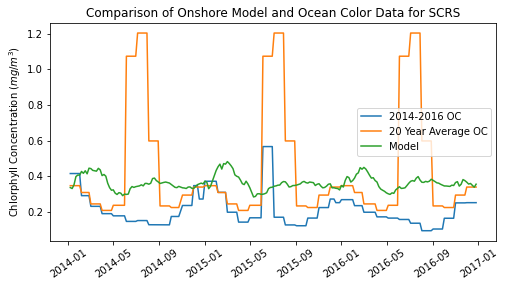

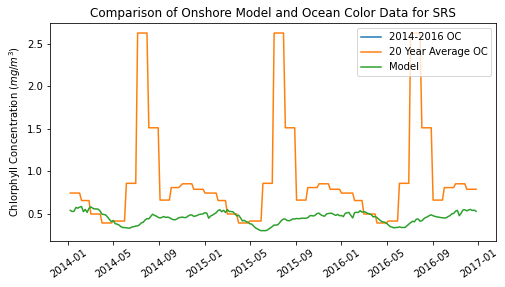

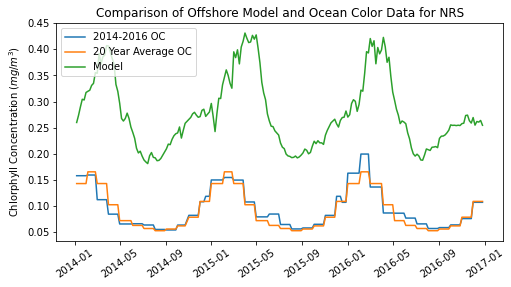

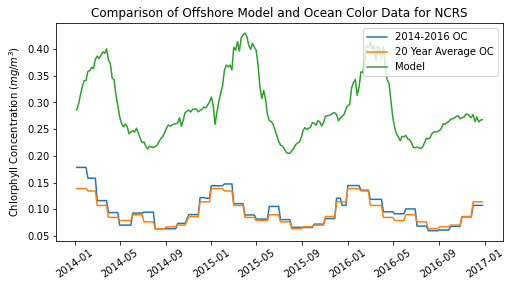

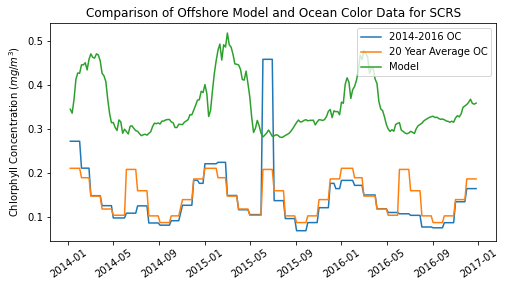

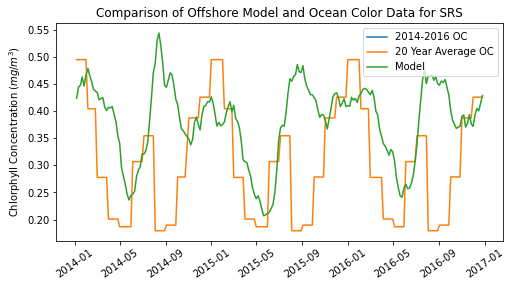

In [34]:
#Plot final plots of oc model comparisons onshore vs offshore
regions = ['N', 'NC', 'SC', 'S']
for i in range(4):
    plt.figure(i, figsize=(8,4))
    plt.plot(total_time, shore_oc_1415_final[i])
    plt.plot(total_time, shore_oc_ma_1415_final[i])
    plt.plot(total_time, shore_model_box_array_final[i])
    plt.legend(['2014-2016 OC', '20 Year Average OC', 'Model'])
    plt.ylabel(r'Chlorphyll Concentration ($mg/m^3$)') 
    plt.xticks(rotation = 35)
    plt.title('Comparison of Onshore Model and Ocean Color Data for {}RS'.format(regions[i]))
    plt.savefig('modeloc1415on2_{}RS.png'.format(regions[i]), bbox_inches = 'tight')

for i in range(4):
    plt.figure(i+4, figsize=(8,4))
    plt.plot(total_time, offshore_oc_1415_final[i])
    plt.plot(total_time, offshore_oc_ma_1415_final[i])
    plt.plot(total_time, offshore_model_box_array_final[i])
    plt.legend(['2014-2016 OC', '20 Year Average OC', 'Model'])
    plt.ylabel(r'Chlorphyll Concentration ($mg/m^3$)') 
    plt.title('Comparison of Offshore Model and Ocean Color Data for {}RS'.format(regions[i]))
    plt.xticks(rotation = 35)
    plt.savefig('modeloc1415off2_{}RS.png'.format(regions[i]), bbox_inches = 'tight')

## Compare model data to float data

This is data from an Argo float traveling near the west coast of the northern red sea. In order to compare this data to the modeled data, the glider data has to be sampled from the same locations and nearest times to the float data.

In [3]:
#Load North Float
nfloat_meta = pd.read_csv('/home/panaylor/RedSea/ssh_redsea/nfloat_meta.csv')
nfloat_chla = np.loadtxt('/home/panaylor/RedSea/ssh_redsea/nfloat_chla.csv',dtype=str, delimiter=',')

In [5]:
#Convert data into a readable format for python
nfloat_chla[nfloat_chla == 'NA'] = np.float('NaN')
nfloat_chla = nfloat_chla.astype('float64')

nDates = nfloat_meta['Dates'][:168]
for i in range(168):
    nDates[i] = pd.to_datetime(nDates[i], format= '%d-%b-%y')
print(nDates)

0      2015-09-30 00:00:00
1      2015-10-01 00:00:00
2      2015-10-02 00:00:00
3      2015-10-03 00:00:00
4      2015-10-04 00:00:00
              ...         
163    2017-01-30 00:00:00
164    2017-02-04 00:00:00
165    2017-02-09 00:00:00
166    2017-02-14 00:00:00
167    2017-02-19 00:00:00
Name: Dates, Length: 168, dtype: object


Below are two blocks of code where the model data is sampled from the nearest point to the glider data. This is based on time of year, latitude, and longitude. Because the model is of fairly high resolution the pulled locations are very close to those reported by the float. These represent two different runs which have slightly different initial         conditions.

In [ ]:
#match model data points to north float data points
ndates = []
for i in range(len(nDates)):
    ndates.append(np.datetime64(nDates[i]))

nfloat_accurate = []
for i in range(154):
    if( i<43):
        temp = chla_15.sel(time=ndates[i], method='nearest').sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        nfloat_accurate.append(temp['BLGCHL'][:])
    elif(i>42 & i< 155):
        temp0 = chla_16.sel(time = ndates[i], method='nearest')
        temp = temp0.sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        nfloat_accurate.append(temp['BLGCHL'][:])
nfloat_accurate = np.flip(np.rot90(np.array(nfloat_accurate),3),1)

In [ ]:
#continued for second run
ndates = []
for i in range(len(nDates)):
    ndates.append(np.datetime64(nDates[i]))

nfloat_accurate2 = []
for i in range(154):
    if( i<43):
        temp = chla_152.sel(time=ndates[i], method='nearest').sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        print(np.shape(temp['BLGCHL']))
        nfloat_accurate2.append(temp['BLGCHL'][:])
    elif(i>42 & i< 155):
        temp0 = chla_162.sel(time = ndates[i], method='nearest')
        temp = temp0.sel(XC = nfloat_meta['Longitude'][i], method='nearest').sel(YC = nfloat_meta['Latitude'][i], method='nearest')
        nfloat_accurate2.append(temp['BLGCHL'][:])
nfloat_accurate2 = np.flip(np.rot90(np.array(nfloat_accurate2),3),1)

Below is the plot of the two model runs compared to the glider. While the general shape looks good the main issue with this phase of validation was the chlorophyll's distance from the surface, particularly in the summer and fall.

<ipython-input-11-98067387c8b8>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)


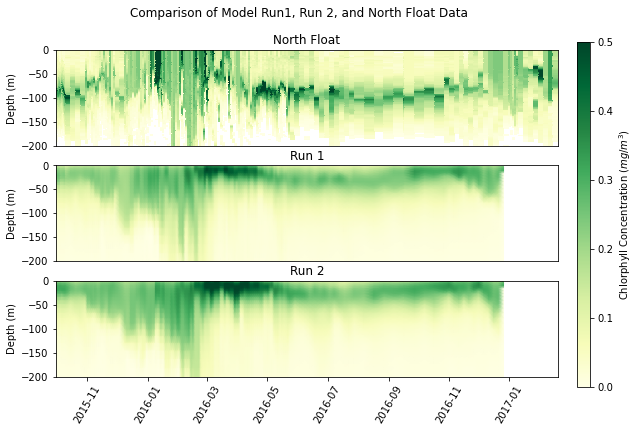

In [11]:
#plot north float data compared to two runs of modeled data
nDates_array = np.array(nDates)
fig = plt.figure(1, figsize=(9,6))
plt.subplot(311)
im = plt.pcolormesh(nDates, -1*nfloat_meta['Pressure'], nfloat_chla[:,:168],cmap='YlGn', vmin = 0, vmax = .5)
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('North Float')
plt.ylabel('Depth (m)')
plt.xticks([])
plt.xlim([nDates_array[0], nDates_array[-1]])
#plt.savefig('Chl_nfloat.png', bbox_inches='tight')
#ax.set_xlim([total_time[0], nDates_array[-1]])
plt.subplot(312)
im2 = plt.pcolormesh(nDates[:154], chla['Z'][:21],nfloat_accurate[:21,:], vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 1')
plt.xlim([nDates_array[0], nDates_array[-1]])
plt.xticks([])
plt.subplot(313)
im2 = plt.pcolormesh(nDates[:154], chla['Z'][:21],nfloat_accurate2[:21,:], vmin =0, vmax = .5, cmap = 'YlGn', shading='Gouraud')
plt.xticks(rotation=60)
plt.ylabel('Depth (m)')
plt.ylim([-200, 0])
#plt.colorbar(label = r'Chlorphyll Concentration ($mg/m^3$)')
plt.title('Run 2')
plt.xlim([nDates_array[0], nDates_array[-1]])
cb_ax = fig.add_axes([.93, .1,.02,.8])
fig.colorbar(im, cax=cb_ax, label =  r'Chlorphyll Concentration ($mg/m^3$)')
plt.suptitle('Comparison of Model Run1, Run 2, and North Float Data')
plt.savefig('r1vr2_nf_chl_accurate.png',bbox_inches = 'tight')

# Close nitrate budget to understand nitrate movement

In order to identify what is causing the issues with chlorphyll depth, it was necessary to understand the movement of nutrients. Through some other analysis we found that the system was nitrate limited so it was crucial to close the nitrate budget to understand the relevant fluxes. 

In [1]:
import os,sys
import numpy as np
from scipy.io import loadmat,savemat
import h5py

These are the relevant flux terms from the model. These terms have approximately the same dimensions as the earlier data. These terms describe all of the ways that nitrate can enter the relevant region.

In [ ]:
# Load data
prefix = ''

#Advection
FLUXrf = xr.open_dataset(prefix + '_2014_ADVrNO3.nc')
FLUXxf = xr.open_dataset(prefix + '_2016_ADVxNO3.nc')
FLUXyf = xr.open_dataset(prefix + '_2016_ADVyNO3.nc')

#Diffusion
DIFFrf = xr.open_dataset(prefix + '_2016_DFrINO3.nc')
DIFFxf = xr.open_dataset(prefix + '_2016_DFxENO3.nc')
DIFFyf = xr.open_dataset(prefix + '_2016_DFyENO3.nc')

#Biological flux
BLGf = xr.open_dataset(prefix + '_2016_BLGBION.nc')

#Radiative forcing
FORCf = xr.open_dataset(prefix + '_2016_ForcNO3.nc')

#Current
Uvelf = xr.open_dataset(prefix + '_2016_Snaps_Uvel.nc')
Vvelf = xr.open_dataset(prefix + '_2016_Snaps_Vvel.nc')
Wvelf = xr.open_dataset(prefix + '_2016_Snaps_Wvel.nc')

#Nitrate
WNO3f = xr.open_dataset(prefix + '_2016_WNO3.nc')
NO3f = xr.open_dataset(prefix + '_2016_Snaps_NO3.nc')

In [ ]:
#Load grid dimension files
mat = '/data/SO2/RedSea/GRID/grid.mat'
grid = {}
f = h5py.File(mat)
for k, v in f.items():
    grid[k] = np.array(v)
    #print(k)
print(grid.keys())

Every data point represents a three dimensional space at an instance of time. These spaces vary is size based on latitude and depth. These grid values are used to calculate surface area and volume values to properly examine the region.

In [5]:
# Format grid data

dt = 86400*5
nt = 72
XC = grid['XC'][0,:]
YC = grid['YC'][:,0]
RC = grid['RC'][0,:]
RAC = NO3f['rA'][:,:]
DYG = grid['DYG'][:,:]
DXG = grid['DXG'][:,:]
DRF = grid['DRF'][0,:]
hFacW = grid['hFacW'][:,:,:]
hFacC = grid['hFacC'][:,:,:]
hFacS = grid['hFacS'][:,:,:]

len_x = len(XC)
len_y = len(YC)
len_z = len(RC)

xel = np.arange(0,len_x-1, 1)
yel = np.arange(0,len_y-1, 1)
zel = np.arange(0,len_z-1, 1)

nx = len(xel)
ny = len(yel)
nz = len(zel)


In [6]:
#Create surface areas and volumes of data regions

volume = np.zeros((nz,ny,nx), '>f4')
AREAWEST = np.zeros((nz, ny, nx+1), '>f4')
AREASOUTH = np.zeros((nz, ny+1, nx), '>f4')
AREACELL = np.zeros((nz+1, ny, nx), '>f4')

for k in range(nz):
    volume[k,...] = (hFacC[k,yel[0]:yel[-1]+1,xel]*RAC[yel[0]:yel[-1]+1,xel].transpose()*DRF[k]).transpose()
    AREACELL[k,...]  = RAC[yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    AREAWEST[k,...]  = DYG[yel,xel[0]:xel[-1]+2]*DRF[k]*hFacW[k,yel,xel[0]:xel[-1]+2]
    AREASOUTH[k,...] = DXG[yel[0]:yel[-1]+2,xel]*DRF[k]*hFacS[k,yel[0]:yel[-1]+2,xel].transpose()

To understand the varius nitrate inputs, its important to understand the actual change in nitrate concentration which is calculated below. This is accomplished by finding the time derivative of the nitrate concentration.

In [7]:
#calculate nitrate change

DZ         = np.nan*np.ones((nz,ny,nx),'>f4')
DRF1       = np.nan*np.ones((nz,ny,nx),'>f4')
DRF        = DRF[:nz]
for kk in range(nz):
    DRF1[kk,...] = DRF[kk]
    DZ[kk,...]   = DRF[kk]*hFacC[k,yel[0]:yel[-1]+1,xel].transpose()
    
Tr = np.array(NO3f['TRAC04'][:,:,:,:])
dTrdt      = np.diff(Tr[:,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1], axis = 0)/dt
print(np.shape(dTrdt))

(71, 49, 1999, 1999)


In [8]:
ADV_x      = np.nan*np.zeros((nz,ny,nx),'>f4')
ADV_y      = np.nan*np.zeros((nz,ny,nx),'>f4')
ADV_z      = np.nan*np.zeros((nz,ny,nx),'>f4')

DIV_x      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_y      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_z      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_t = np.zeros((nt,nz,ny,nx), '>f4')

DIFF_x     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_y     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_z     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_n = np.zeros((nz,ny,nx), '>f4')

BIO        = np.nan*np.zeros((nz,ny,nx),'>f4')

# Correction due to vertical advection (WTRAC06)
CORR       = np.zeros((nz,ny,nx),'>f4')
ADVcorr = np.zeros((nz,ny,nx),'>f4')
RES = np.zeros((nz,ny,nx), '>f4')
ADVn = np.zeros((nz,ny,nx), '>f4')
ADVx_int1 = []
ADVy_int1 = []
ADVz_int1 = []
DIFFx_int1 = []
DIFFy_int1 = []
DIFFz_int1 = []
BIO_int1 = []
ADVn_int1 = []
dTrdt_int1 = []


This program uses the divergence theorem to find the volume integrated divergence of nitrate concentration. By finding the  time derivatives of the surface fluxes the volume integrated divergence can be found. This code finds the time derivative at each instance. This code is applied to a NCRS regions as defined earlier.
    
$$
\int_{\partial V}F_{ADV} \cdot da + \int_{\partial V}F_{ADV} \cdot da + \int_{\partial V}F_{BIO} \cdot da = \int_V (\nabla \cdot F_{NO3})dV
$$

In [ ]:
for tt in range(nt):

    FLUXx      = np.array(FLUXxf['ADVxTr04'][tt,:,:,:])

    FLUXy      = np.array(FLUXyf['ADVyTr04'][tt,:,:,:])

    FLUXz      = np.array(FLUXrf['ADVrTr04'][tt,:,:,:])


    # - uptake + remin + sed (mol/m3/s)

    BIOf       = np.array(BLGf['BLGBION'][tt,:,:,:])

    DIFFx      = np.array(DIFFxf['DFxETr04'][tt,:,:,:])

    DIFFy      = np.array(DIFFyf['DFyETr04'][tt,:,:,:])

    DIFFz      = np.array(DIFFrf['DFrITr04'][tt,:,:,:])

    FORC       = np.array(FORCf['ForcTr04'][tt,:,:,:])



    fieldU     = np.array(Uvelf['UVEL'][tt,:,:,:])

    fieldV     = np.array(Vvelf['VVEL'][tt,:,:,:])

    fieldW     = np.array(Wvelf['WVEL'][tt,:,:,:])

    fieldCorr  = np.array(WNO3f['WTRAC04'][tt,:,:,:])
    
    # Advection (div(bar(u)*tr))
    ADV_x[...] = np.diff(FLUXx[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2],axis=2)/volume
    ADV_y[...] = np.diff(FLUXy[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1],axis=1)/volume
    ADV_z[...] = -np.diff(FLUXz[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1],axis=0)/volume
    
    # Divergence (nabla.u) * tr
    U     = fieldU[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2]*AREAWEST
    V     = fieldV[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1]*AREASOUTH
    W     = fieldW[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]*AREACELL
    W[0,...] = 0
    
    # gradients:
    print(np.shape(DIV_y),np.shape(np.diff(V[:,:,:], axis=1)), np.shape(volume[:,:,:]), np.shape(Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]))
    DIV_z[:,...]  = -1*((np.diff(W[:,:,:], axis = 0)/volume[:,...])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1])
    DIV_y[:,:,:]  = (np.diff(V[:,:,:],axis = 1)/volume[:,:,:])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    DIV_x[...,:]  = (np.diff(U[:,:,:],axis = 2)/volume[...,:])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # compute DIC*DIV_vec(U)
    DIV_t[...]  = DIV_x[...]+DIV_y[...]-DIV_z[...]
    ADVn[...] = ((-1*ADV_x[...])+(-1 * ADV_y[...])+(-1*ADV_z[...]))

    # Diffusion
    DIFF_x[...]  = np.diff(DIFFx[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2],axis=2)/volume
    DIFF_y[...]  = np.diff(DIFFy[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1],axis=1)/volume
    DIFF_z[...]  = -1*np.diff(DIFFz[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1],axis=0)/volume

    DIFF_horiz  = (-1*DIFF_x[...]) + (-1*DIFF_y[...])
    DIFF        = DIFF_horiz + (-1*DIFF_z[...] )
    DIFF_n[...]       = DIFF
    
    # Biological term
    BIO[...] = BIOf[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # Aeolian deposition
    #DEPO[tt,...] = FORC[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # correction to vertical advection at z=0
    CORR[0,...] = fieldCorr[0,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]/DZ[0,...]
    
    # remove correction from advection:
    ADVcorr[...] = ADVn[...] - CORR[...]

    ADVx_int1.append(np.nansum(ADV_x[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVy_int1.append(np.nansum(ADV_y[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVz_int1.append(np.nansum(ADV_z[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFx_int1.append(np.nansum(DIFF_x[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFy_int1.append(np.nansum(DIFF_y[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFz_int1.append(np.nansum(DIFF_z[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    BIO_int1.append(np.nansum(BIO[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    dTrdt_int1.append(np.nansum(dTrdt[tt,:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVn_int1.append(np.nansum(ADVcorr[:8,1200:1550,:]*volume[:8,1200:1550,:]))

    print(int(tt/nt))
   

In [10]:
#Sign Correction
ADVz_int1 = -1*np.array(ADVz_int1)
ADVy_int1 = -1*np.array(ADVy_int1)
ADVx_int1 = -1*np.array(ADVx_int1)
DIFFz_int1 = -1*np.array(DIFFz_int1)
DIFFy_int1 = -1*np.array(DIFFy_int1)
DIFFx_int1 = -1*np.array(DIFFx_int1)
BIO_int1 = np.array(BIO_int1)
dTrdt_int1 = np.array(dTrdt_int1)
ADVcorr_int1 = np.array(ADVn_int1)

In [12]:
#Save solutions in data array
data_array = np.ones((9,71))
data_array[0,:] = ADVx_int1[1:]
data_array[1,:] = ADVy_int1[1:]
data_array[2,:] = ADVz_int1[1:]
data_array[3,:] = DIFFx_int1[1:]
data_array[4,:] = DIFFy_int1[1:]
data_array[5,:] = DIFFz_int1[1:]
data_array[6,:] = BIO_int1[1:]
data_array[7,:] = dTrdt_int1[:]
data_array[8,:] = ADVcorr_int1[:]
np.savetxt('path/panaylor/budget_ints_run2_2016.csv', data_array)

Below is the result over two years of the model. It's clear that during the winter there is a combination of increased  physical mixing and biological productivity. Most of the nitrate is entering the system through vertical diffusion and  latitudinal advection. Most of the nitrate loss in the system is due to biological consumption.

[-8.56131775e+02 -3.14400116e+02  2.92460388e+02  3.09269085e+01
  5.85686096e+02 -1.63368286e+03 -4.62124084e+02  9.40684875e+02
 -1.04219116e+03  4.15942932e+02  1.50705872e+03  2.46794205e+02
  3.38725281e+02  4.93873688e+02 -1.04035263e+02  5.38719299e+02
 -5.23592651e+02  1.00208167e+03 -4.16427460e+02  1.75411758e+02
  1.54059436e+03 -4.61288452e-01  8.19656738e+02  1.32783545e+03
  8.58426453e+02  4.48106689e+01 -1.05835251e+02 -3.21169586e+01
 -1.01298688e+03  1.03578514e+02 -4.21886230e+02  8.36841278e+01
 -6.78602539e+02  4.97958130e+02 -4.11340271e+02  4.95966187e+01
 -2.42170883e+02 -8.90397263e+01  7.49061661e+01  8.32351761e+01
 -9.78650391e+02  6.99309082e+02  5.75436211e+00  4.99664154e+02
 -2.30001099e+02  8.51901245e+00 -1.57595932e+02  7.67676697e+01
  2.76013733e+02 -9.71740662e+02  4.76169662e+01 -7.62384033e+01
 -5.69601318e+02 -2.95023193e+02 -2.56580994e+02  9.42215729e+01
 -1.31403122e+02 -2.70025146e+02 -1.60533279e+02 -3.04812592e+02
  3.64201538e+02 -4.47548

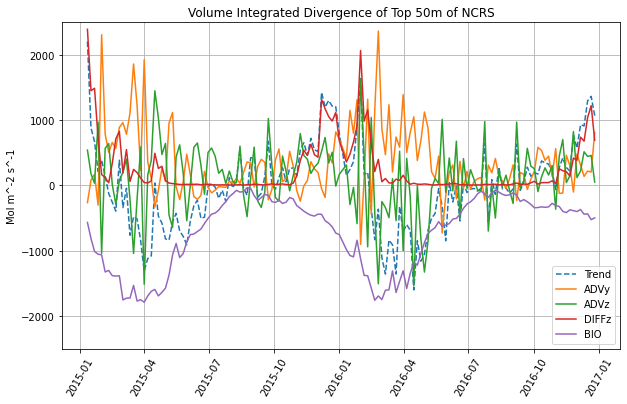

In [26]:
print(ADVz_int1*-1)
plt.figure(figsize=(10,6))
plt.plot(time, data_1516[7,:], linestyle = '--', linewidth=1.5)
plt.plot(time,data_1516[1,:])
plt.plot(time,data_1516[2,:])
#plt.plot(NO3f['time'][1:],DIFFx_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFy_int1[1:])
plt.plot(time,data_1516[5,:])
plt.plot(time,data_1516[6,:])
plt.legend([ 'Trend', 'ADVy', 'ADVz','DIFFz', 'BIO'])
plt.grid(True)
#plt.plot(NO3f['time'][1:], np.zeros(72), linestyle = '--', color = 'grey')
plt.ylabel('Mol m^-2 s^-1')
plt.title('Volume Integrated Divergence of Top 50m of NCRS')
plt.ylim([-2500, 2500])
plt.xticks(rotation=60)
plt.savefig('figures/Volume_Integrated_Divergence_top50_ncrs1516.png', bbox_inches = 'tight')

[-8.56131775e+02 -3.14400116e+02  2.92460388e+02  3.09269085e+01
  5.85686096e+02 -1.63368286e+03 -4.62124084e+02  9.40684875e+02
 -1.04219116e+03  4.15942932e+02  1.50705872e+03  2.46794205e+02
  3.38725281e+02  4.93873688e+02 -1.04035263e+02  5.38719299e+02
 -5.23592651e+02  1.00208167e+03 -4.16427460e+02  1.75411758e+02
  1.54059436e+03 -4.61288452e-01  8.19656738e+02  1.32783545e+03
  8.58426453e+02  4.48106689e+01 -1.05835251e+02 -3.21169586e+01
 -1.01298688e+03  1.03578514e+02 -4.21886230e+02  8.36841278e+01
 -6.78602539e+02  4.97958130e+02 -4.11340271e+02  4.95966187e+01
 -2.42170883e+02 -8.90397263e+01  7.49061661e+01  8.32351761e+01
 -9.78650391e+02  6.99309082e+02  5.75436211e+00  4.99664154e+02
 -2.30001099e+02  8.51901245e+00 -1.57595932e+02  7.67676697e+01
  2.76013733e+02 -9.71740662e+02  4.76169662e+01 -7.62384033e+01
 -5.69601318e+02 -2.95023193e+02 -2.56580994e+02  9.42215729e+01
 -1.31403122e+02 -2.70025146e+02 -1.60533279e+02 -3.04812592e+02
  3.64201538e+02 -4.47548

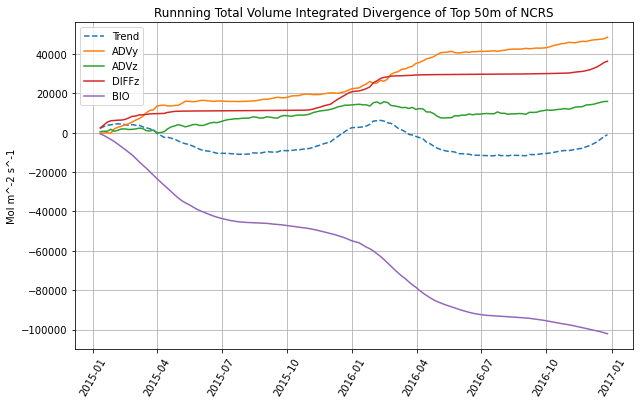

In [29]:
print(ADVz_int1*-1)
plt.figure(figsize=(10,6))
plt.plot(time, np.cumsum(data_1516[7,:]), linestyle = '--', linewidth=1.5)
plt.plot(time,np.cumsum(data_1516[1,:]))
plt.plot(time,np.cumsum(data_1516[2,:]))
#plt.plot(NO3f['time'][1:],DIFFx_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFy_int1[1:])
plt.plot(time,np.cumsum(data_1516[5,:]))
plt.plot(time,np.cumsum(data_1516[6,:]))
plt.legend([ 'Trend', 'ADVy', 'ADVz','DIFFz', 'BIO'])
plt.grid(True)
#plt.plot(NO3f['time'][1:], np.zeros(72), linestyle = '--', color = 'grey')
plt.ylabel('Mol m^-2 s^-1')
plt.title('Runnning Total Volume Integrated Divergence of Top 50m of NCRS')
#plt.ylim([-2500, 2500])
plt.xticks(rotation=60)
plt.savefig('figures/Volume_Integrated_Divergence_top50_ncrs1516_cum.png', bbox_inches = 'tight')

The running total figure shows the relative importance of biological productivity within the system. This data pointed us in the direction of understanding how issues with our biological modeling might be effecting our nitrate concentrations. To correct these issues we began by adjusting the growth rate constant.